In [47]:
# All imports required for analysis are below
from __future__ import print_function
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import ipywidgets
from ipywidgets import widgets as wd
import sklearn
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics as mt
from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
import glob
import os

In [48]:
# Loading in HTML/CSS packages for use within the notebook
from IPython.core.display import HTML
HTML("<link href='https://fonts.googleapis.com/css?family=Passion+One' rel='stylesheet' type='text/css'><style>div.attn { font-family: 'Helvetica Neue'; font-size: 30px; line-height: 40px; color: #FFFFFF; text-align: center; margin: 30px 0; border-width: 10px 0; border-style: solid; border-color: #5AAAAA; padding: 30px 0; background-color: #DDDDFF; }hr { border: 0; background-color: #ffffff; border-top: 1px solid black; }hr.major { border-top: 10px solid #5AAA5A; }hr.minor { border: none; background-color: #ffffff; border-top: 5px dotted #CC3333; }div.bubble { width: 65%; padding: 20px; background: #DDDDDD; border-radius: 15px; margin: 0 auto; font-style: italic; color: #f00; }em { color: #AAA; }div.c1{visibility:hidden;margin:0;height:0;}div.note{color:red;}</style>")

# Mini Lab: Logistic Regression and SVMs
### Group A: Mai Loan Tran, Lei Jiang, Zachary Gill, & Samantha Sprague

## Table of Contents for Mini Lab
* <a href="#Introduction">Introduction</a>
* <a href="#CreateModels">Create Models</a>
* <a href="#ModelAdvantages">Model Advantages</a>
* <a href="#InterpretFeatureImportance">Interpret Feature Importance</a>
* <a href="#InterpretSupportVectors">Interpret Support Vectors</a>
* <a href="#Exceptional Work">Exceptional Work</a>
* <a href="#References">References</a>


<a id="Introduction"></a>
## Introduction


Diabetes is the leading cause of death in the world. Roughly 422 million people have diabetes. There are three major types of diabetes: type 1, type 2, and gestational diabetes. Type 2 is the most common type of diabetes, and is thought to be preventable! While the leading cause of death, with identification and proper management of diabetes most individuals can lead happy and healthy lives. The key to manageable diabetes is often early detection and proper treatment. This begs the question, can we detect if a patient will be readmitted in the hospital for diabetes? This notebook will guide the reader through a comprehensive analysis that evaluates our ability to predict readmission to the hospital for diabetes using logistic regression and support vector machine techniques. 


The exploratory data analysis for this dataset is provided the additional notebook submitted for this assignment. Due to Professor Moustafa's request, this work was not included in the notebook for ease of grading the assignment, but is available to validate extensive work was done for cleaning the data, and generating useful features for predictive analysis.

<a id="CreateModels"></a>
## Create Models

**Requirements:** Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate.

In [49]:
# Reading in cleaned data
directory = '/Users/samanthasprague/Downloads/'
df_zg = pd.read_csv(directory + 'Diabetic_Cleaned.csv')
print("Done reading data.")

Done reading data.


In [50]:
# The following code chunks are to manipulate data types for ease of analysis
ordinal = ["age", "time_in_hospital"]
categorical = ["race", "gender", "admission_type_id", "discharge_disposition_id",
               "admission_source_id", "medical_specialty", "max_glu_serum",
               "A1Cresult", "change", "diabetesMed", "diag_1_val", "diag_2_val",
               "diag_3_val", "meds_increased"]
continuous = ["num_lab_procedures", "num_procedures", "num_medications",
              "number_outpatient", "number_emergency", "number_inpatient",
              "number_diagnoses", "medication_count"]
medicines = ["metformin", "repaglinide", "nateglinide", "chlorpropamide",
             "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide",
             "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
             "tolazamide", "insulin", "glyburide-metformin", "glipizide-metformin",
             "metformin-rosiglitazone", "metformin-pioglitazone"]
response = ["readmitted_tf"]

In [51]:
df_zg_ordinal = df_zg[ordinal]
df_zg_categorical = df_zg[categorical]
df_zg_continuous = df_zg[continuous]
df_zg_medicines = df_zg[medicines]
df_zg_response = df_zg[response]

In [52]:
# Loop that makes the age Ordinal
for i in range(0, 10):
    val = "[" + str(i*10) + "-" + str((i+1)*10) + ")"
    df_zg_ordinal.loc[df_zg_ordinal['age'] == val, 'age'] = i

In [53]:
#Make all categorical columns categorical
df_zg_categorical['admission_type_id'] = df_zg_categorical['admission_type_id'].astype(object)
df_zg_categorical['discharge_disposition_id'] = df_zg_categorical['discharge_disposition_id'].astype(object)
df_zg_categorical['admission_source_id'] = df_zg_categorical['admission_source_id'].astype(object)
df_zg_categorical['admission_type_id'] = df_zg_categorical['admission_type_id'].astype(object)
df_zg_categorical['meds_increased'] = df_zg_categorical['meds_increased'].astype(object)
print("Done")

Done


In [54]:
#Creating X and Y dataframes
df_zg_x = pd.concat([df_zg_ordinal, df_zg_categorical, df_zg_continuous], axis = 1)
df_zg_num_x = pd.concat([df_zg_ordinal, df_zg_continuous], axis = 1)
df_zg_med_x = pd.concat([df_zg_ordinal, df_zg_categorical, df_zg_continuous, df_zg_medicines], axis = 1)
df_zg_hot_x = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous], axis = 1)
df_zg_hot_med_x = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous, pd.get_dummies(df_zg_medicines)], axis = 1)
df_zg_y = df_zg_response
print("Done")

Done


### Training and Testing Split

There are several train and test splits done for the several types of models we will build in later sections in order to evaluate which set of features gives the highest accuracy. Due to our dataset, there were a lot of categorical variables that measured if a patient was taking a specific type of medication. This made our feature list very long, but difficult to leverage in models like logistic regression and SVMs because they were categorical. In addition, these categorical variables were highly skewed (as seen in the EDA analysis). We did not know how the models would perform if we included all the categorical medications, as we have often seen, simipilar models do not overfit and often provide better generalizations for test sets. These training and test sets are split 80/20. 

In [56]:
#Code for 80/20 Training and Testing Splits 

#Hot Encoded, Not Scaled, Not including meds----------------
x_train_h, x_test_h, y_train_h, y_test_h = train_test_split(df_zg_hot_x, df_zg_y, test_size = 0.2, random_state=7)

#Hot Encoded, Not Scaled, Including meds--------------------
x_train_hm, x_test_hm, y_train_hm, y_test_hm = train_test_split(df_zg_hot_med_x, df_zg_y, test_size = 0.2, random_state=7)

#Hot Encoded, Scaled, No Meds-------------------------------
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()
scl_obj.fit(x_train_h)
x_train_hs = scl_obj.transform(x_train_h)
x_test_hs = scl_obj.transform(x_test_h)

#Hot Encoded, Scaled, Including Meds------------------------
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()
scl_obj.fit(x_train_hm)
x_train_hsm = scl_obj.transform(x_train_hm)
x_test_hsm = scl_obj.transform(x_test_hm)

#Reseting the row indexes
x_train_h.reset_index()
y_train_h.reset_index()
x_train_hm.reset_index()
y_train_hm.reset_index()

x_test_h.reset_index()
y_test_h.reset_index()
x_test_hm.reset_index()
y_test_hm.reset_index()

x_train_h.shape, x_test_h.shape

((81412, 184), (20354, 184))

## Logistic Regression Models

###### Functions for Logistic Regression

In [57]:
# A function to find the optimal cutoff point from ROC curve

#https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def Find_Optimal_Cutoff(target, predicted):
    """Parameters:
    target : Matrix with dependent or target data, where rows are observations
    predicted : Matrix with predicted data, where rows are observations
    ----------
    Return: list type, with optimal cutoff value
    """
    predicted = predicted[:,1]
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#probs is the result of a model.predict_proba(x_test) call
#This function plots an ROC curve
def rocCurvePlot(probs, y_test):
    # calculate the fpr and tpr for all thresholds of the classification
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### LR 1 -- One hot encoded variables, not scaled, not included medications

discharge_disposition_id_11 has weight of -5.680724762292217
discharge_disposition_id_14 has weight of -2.7007664786403662
discharge_disposition_id_13 has weight of -1.7701205910455997
admission_source_id_9 has weight of -1.4278503008815386
discharge_disposition_id_19 has weight of -0.951771026386359
medical_specialty_Surgery-Cardiovascular/Thoracic has weight of -0.9386964892651906
admission_source_id_5 has weight of -0.8239987068889928
admission_type_id_4 has weight of -0.7705805454235881
glyburide-metformin_Up has weight of -0.7488316841142529
admission_source_id_4 has weight of -0.7368363511651741
admission_source_id_6 has weight of -0.7258813003288298
medical_specialty_Pediatrics-Endocrinology has weight of -0.7199296293310108
admission_type_id_3 has weight of -0.7130129215052432
medical_specialty_DCPTEAM has weight of -0.6626881392345174
admission_type_id_5 has weight of -0.6605023597250048
admission_type_id_8 has weight of -0.6558041832930482
admission_source_id_2 has weight of 

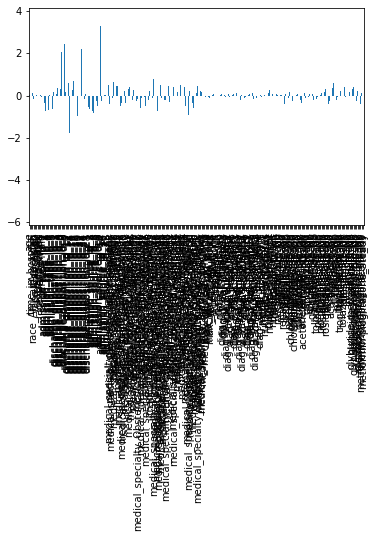

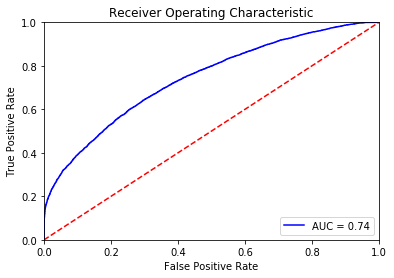

F1: 0.67150677815738 ACC: 0.6710720251547607 AUC: 0.7419335150598532 
Confusion Matrix
 [[7368 3601]
 [3094 6291]]
CPU times: user 14.9 s, sys: 1.61 s, total: 16.5 s
Wall time: 15.4 s


In [58]:
%%time
#Code fro LR 1
#Logistic Regression: Hot Encoded, Not Scaled, Not including meds
model = LogisticRegression()
model.fit(x_train_hm, y_train_hm)

#Print all of the coefficient weights
weights = model.coef_.T
variable_names = x_train_hm.columns
allWeight = zip(weights, variable_names)
allWeight = sorted(allWeight, key=lambda x: x[0])
for coef, name in allWeight:
    print(name, 'has weight of', coef[0])

#Bar plot of the coefficient weights
pd.Series(model.coef_[0].T,index=x_train_hm.columns).plot(kind = 'bar')
plt.show()

#Find the optimal cutoff point
y_pred_cut = model.predict_proba(x_train_hm)
cutoff = Find_Optimal_Cutoff(y_train_hm, y_pred_cut)

#Prediction
#y_pred = model.predict(x_test_scaled)
y_pred_probs = model.predict_proba(x_test_hm)
y_pred = np.where(y_pred_probs >= cutoff, 1, 0)
y_pred = y_pred[:,1]

rocCurvePlot(y_pred_probs, y_test_hm)

#Accuracy metrics
f1 = f1_score(y_test_hm, y_pred, average = 'weighted')
acc = accuracy_score(y_test_hm, y_pred)
roc = roc_auc_score(y_test_hm, model.predict_proba(x_test_hm)[:,1])
conf = mt.confusion_matrix(y_test_hm, y_pred)
print("F1:", f1, "ACC:", acc, "AUC:", roc, "\nConfusion Matrix\n", conf)

### LR 2 -- SGD Logistic Regression w/ one hot encoded features, scaled, including medication variables

discharge_disposition_id_11 has weight of -0.21334309212193683
discharge_disposition_id_14 has weight of -0.08370726590197551
discharge_disposition_id_13 has weight of -0.07047030589946678
admission_source_id_2 has weight of -0.05942823746203681
admission_type_id_3 has weight of -0.05567540222039955
admission_type_id_4 has weight of -0.05050096294174235
medical_specialty_Surgery-Cardiovascular/Thoracic has weight of -0.048510136752488296
discharge_disposition_id_1 has weight of -0.045544547151162074
medical_specialty_InternalMedicine has weight of -0.045144389208571736
discharge_disposition_id_18 has weight of -0.03865347081129354
discharge_disposition_id_3 has weight of -0.03831515129718058
admission_source_id_1 has weight of -0.03761050585034213
medical_specialty_Orthopedics-Reconstructive has weight of -0.03687240781171957
medical_specialty_ObstetricsandGynecology has weight of -0.03686119362245745
race_Unspecified has weight of -0.03447381072837436
diabetesMed_No has weight of -0.0

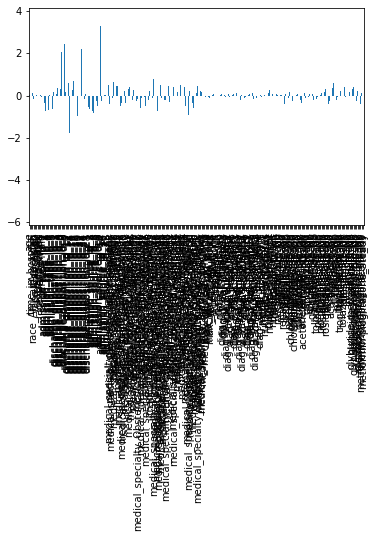

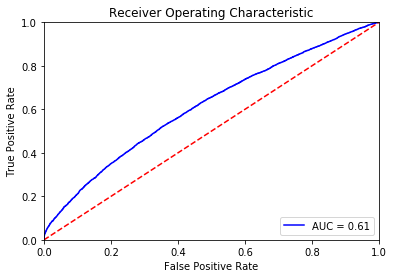

F1: 0.581541703561913 ACC: 0.5809177557236906 AUC: 0.6145363309676959 
Confusion Matrix
 [[6362 4607]
 [3923 5462]]
CPU times: user 7.82 s, sys: 2.23 s, total: 10 s
Wall time: 8.96 s


In [84]:
%%time
#Code for LR 2
#SGD Logistic Regression: Hot encoded, Including Medications
regularize_const = 0.1
iterations = 5
# use some compact notation for creating a logistic regression classifier with stochastic descent
log_sgd = SGDClassifier(alpha = regularize_const,
        fit_intercept = True, l1_ratio = 0.0, learning_rate = 'optimal',
        loss = 'log', n_jobs = -1, penalty = 'l2')
cv = StratifiedShuffleSplit( n_splits = 1, test_size = 0.5 )
scl = StandardScaler()
log_sgd.fit(scl.fit_transform(x_train_hm), y_train_hm)

#Print all of the coefficient weights
weights = log_sgd.coef_.T
variable_names = x_train_hm.columns
allWeight = zip(weights, variable_names)
allWeight = sorted(allWeight, key=lambda x: x[0])
for coef, name in allWeight:
    print(name, 'has weight of', coef[0])

#Bar plot of the coefficient weights
pd.Series(model.coef_[0].T,index=x_train_hm.columns).plot(kind = 'bar')
plt.show()

#Find the optimal cutoff point
y_pred_cut = log_sgd.predict_proba(x_train_hm)
cutoff = Find_Optimal_Cutoff(y_train_hm, y_pred_cut)

#Without the cutoff point changed it predicts all of one class

#Prediction
y_pred_probs = log_sgd.predict_proba(x_test_hm)
y_pred = np.where(y_pred_probs >= cutoff, 1, 0)
y_pred = y_pred[:,1]

rocCurvePlot(y_pred_probs, y_test_hm)

#Accuracy metrics
f1 = f1_score(y_test_hm, y_pred, average = 'weighted')
acc = accuracy_score(y_test_hm, y_pred)
roc = roc_auc_score(y_test_hm, log_sgd.predict_proba(x_test_hm)[:,1])
conf = mt.confusion_matrix(y_test_hm, y_pred)
print("F1:", f1, "ACC:", acc, "AUC:", roc, "\nConfusion Matrix\n", conf)

### LR 3 -- One hot encoded, scaled, includes medications variables in for loop for multiple iterations

In [ ]:
#Code for LR 3
df_mlt_hot = pd.concat([df_zg_hot_x, df_zg_y], axis=1)
from sklearn.model_selection import ShuffleSplit

#Converting the dataframe into a Numpy Matrix
if 'readmitted_tf' in df_mlt_hot:
    y = fdf_mlt_hot['readmitted_tf'].values
    del df_mlt_hot['readmitted_tf']
    X = df_mlt_hot.values
    
num_cv_iterations = 3
num_instances = len(y)
#0.2 indicates the 80/20 split
cv_object = ShuffleSplit(n_splits = num_cv_iterations, test_size = 0.2)

#-----------------------------------------------------
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

iter_num = 0
# Run through the cross validation loop and set the training
# and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]

    #Train the logisitic regression model on the training data
    lr_clf.fit(X_train, y_train)
    
    #Find the optimal cutoff point
    y_pred_cut = lr_clf.predict_proba(X_train)
    cutoff = Find_Optimal_Cutoff(y_train, y_pred_cut)
    y_hat_probs = lr_clf.predict_proba(X_test)
    y_hat = np.where(y_hat_probs >= cutoff, 1, 0)
    y_hat = y_hat[:,1]
    
    rocCurvePlot(y_hat_probs, y_test)

    #Geting the accuracy and confusion matrix for this iteration
    print("==== Iteration:", iter_num, "====")
    f1 = f1_score(y_test, y_hat, average = 'weighted')
    acc = accuracy_score(y_test, y_hat)
    roc = roc_auc_score(y_test, lr_clf.predict_proba(X_test)[:,1])
    conf = mt.confusion_matrix(y_test, y_hat)
    print("F1:", f1, "ACC:", acc, "AUC:", roc, "\nConfusion Matrix\n", conf)

    iter_num+=1

#Print all of the coefficient weights
weights = lr_clf.coef_.T
variable_names = df_mlt_hot.columns
allWeight = zip(weights, variable_names)
allWeight = sorted(allWeight, key = lambda x: x[0])
for coef, name in allWeight:
    print(name, 'has weight of', coef[0])

#Bar plot of the coefficient weights
pd.Series(lr_clf.coef_[0].T,index = df_mlt_hot.columns).plot(kind = 'bar')
plt.show()

### LR 4+ 

###### Other model results
Below are accuracy results of other models we tried during our evaluation, but did not decide to showcase as their results were not nessecarily superiror to those above. 

* Cross Validation, no medications, with SGD - ACC: 58.9%

* No medications, No scaling - ACC: 66.9%

* No medications, scaled - ACC: 66.9%

* Medications, scaled - ACC: 67%

## Support Vector Machine Models

### Data Pre-processing and Transformations for SVM

In [66]:
#Reimporting the data to ensure transformations are not persisted from above analysis.
directory = '/Users/samanthasprague/Downloads/'
df = pd.read_csv(directory + 'Diabetic_Cleaned.csv')
df_clean = df
df_clean.replace('?', np.nan, inplace=True)

We found num_lab_procedures is highly correlated with admission_type_id during EDA. So we would exclude one of them in our model. Below we describe of some of the categorical variables for context in the analysis. 

In [67]:
df_clean[['age','gender','race','diag_1_val','diag_2_val',"admission_source","admission_type","discharge_disposition","insulin"]].describe().transpose()

,count,unique,top,freq
age,101766,10,[70-80),26068
gender,101766,2,Female,54711
race,101766,6,Caucasian,76099
diag_1_val,101766,10,Circulatory,30437
diag_2_val,101766,10,Circulatory,31881
admission_source,95783,14,Physician Referral,36269
admission_type,97684,7,Emergency,32219
discharge_disposition,98086,25,Discharged to home,55967
insulin,101766,4,No,47497


Because the gender attribute binary, there is no need to encode it using OneHotEncoding. We can just convert it to an integer. Age can be coded into int since it is ordinal. However, we should transform the race, diag_1_val attributes to take on different values--one for each possible variable outcome. One hot encoding is all about making the euclid distances even among levels of features. 

Preparing the data for SVM ideally including the following steps in the sequence: one hot encoding, normalize (to make the features contribute equally in euclid distance), PCA, use principle comp for SVM. Refer to this paper for more info on FE: 
https://media.licdn.com/dms/document/C4D1FAQGdKsBchRiF7A/feedshare-document-pdf-analyzed/0?e=1560106800&v=beta&t=toMignhoXC9PRfpoHkzKawyxUSjSCMeZJnBsoPn_SUo. This paper also mentioned log feature help with the skewness. We will use these techniques in the numerous SVM models we train below. 

In [70]:
# Gender transformation
#can also use binary encoder to achieve this
df_clean.gender[df_clean.gender == 'Male'] = 0
df_clean.gender[df_clean.gender == 'Female'] = 1

df_clean["gender"] = df_clean["gender"].astype(int)

In [71]:
#10 age groups; Ordinal encoding
#feature density plot of age can help with answering the question like: does people older age tend to be readmitted?
#can use map/apply function to achieve this

df_clean.age[df_clean.age== '[0-10)'] = 1
df_clean.age[df_clean.age== '[10-20)'] = 2
df_clean.age[df_clean.age== '[20-30)'] = 3
df_clean.age[df_clean.age== '[30-40)'] = 4
df_clean.age[df_clean.age== '[40-50)'] = 5
df_clean.age[df_clean.age== '[50-60)'] = 6
df_clean.age[df_clean.age== '[60-70)'] = 7
df_clean.age[df_clean.age== '[70-80)'] = 8
df_clean.age[df_clean.age== '[80-90)'] = 9
df_clean.age[df_clean.age== '[90-100)'] = 10

df_clean["age"] = df_clean["age"].astype(int)

In [72]:
#one hot encoding categorical variables
#FE based on Feature Importance plot from LR model
#add more important features: discharge_disposition_id, admission_source_id. 
#I think they should be categorical, so I put them in dummy list

dummiesList=["diag_1_val","diag_2_val","diag_3_val","race","A1Cresult","admission_type","insulin","admission_source","discharge_disposition"]
df_clean_wDummies = pd.get_dummies(df_clean[dummiesList])

In [73]:
#combine with numerical features we decide to use and target readmitted_tf

NumFeatures=["num_lab_procedures","number_outpatient","number_emergency", "number_inpatient", "medication_count","number_diagnoses", "gender","age","readmitted_tf"]
df_clean_wDummies= pd.concat((df_clean_wDummies, df_clean[NumFeatures]), axis=1)

In [74]:
#More transformation for SVM analysis
if 'Lnumber_emergency' in df_clean_wDummies:
    del df_clean_wDummies['Lnumber_emergency'] 
    # if 'number_emergency' column still exists, delete it (as we created an ismale column)
if 'Lnum_diagnoses' in df_clean_wDummies:
    del df_clean_wDummies['Lnum_diagnoses']
if 'Lnumber_outpatient' in df_clean_wDummies:
    del df_clean_wDummies['Lnumber_outpatient']    
    
if 'Lnum_lab_procedures' in df_clean_wDummies:
    del df_clean_wDummies['Lnum_lab_procedures'] 
if 'Lnumber_inpatient' in df_clean_wDummies:
    del df_clean_wDummies['Lnumber_inpatient']
    

In [75]:
# Ensuring we have all the correct data types for analysis. 
df_clean_wDummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 99 columns):
diag_1_val_Circulatory                                                                                                             101766 non-null uint8
diag_1_val_Diabeties                                                                                                               101766 non-null uint8
diag_1_val_Digestive                                                                                                               101766 non-null uint8
diag_1_val_Genitourinary                                                                                                           101766 non-null uint8
diag_1_val_Injury                                                                                                                  101766 non-null uint8
diag_1_val_Musculoskeletal                                                                                                  

### Training and Testing Split for SVM

In [76]:
df_imputed=df_clean_wDummies

from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'readmitted_tf' in df_imputed:
    y = df_imputed['readmitted_tf'].values # get the labels we want
    del df_imputed['readmitted_tf'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [77]:
## Training and Testing Split
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]

In [78]:
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

scl_obj.fit(X_train)
X_test_scaled = scl_obj.transform(X_test)

X_train_scaled = scl_obj.transform(X_train) 
# apply to training
X_test_scaled = scl_obj.transform(X_test) 

### SVM 1 - SVM w/ RBF Kernel

In [83]:
##Warning: this cell takes approx 14 minutes run time
#%%time
from sklearn.svm import SVC

# Train model
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

In [86]:
from sklearn import metrics as mt

#Obtaining accuracy for SVM 
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

#Output upfront in case of differing results when running on different computer
#accuracy: 0.6822246241525007
#[[9460 1446]
# [5022 4426]]

accuracy: 0.6728407192689397
[[9380 1513]
 [5146 4315]]


In [87]:
# Looking at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(58255, 98)
(58255,)
[29617 28638]


In [88]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# Now lets look at the support for the vectors and see if we they are indicative of anything
# grab the rows that were selected as support vectors 
#(these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = df_imputed.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['readmitted_tf'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
df_imputed['readmitted_tf'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58255 entries, 61845 to 75227
Data columns (total 99 columns):
diag_1_val_Circulatory                                                                                                             58255 non-null uint8
diag_1_val_Diabeties                                                                                                               58255 non-null uint8
diag_1_val_Digestive                                                                                                               58255 non-null uint8
diag_1_val_Genitourinary                                                                                                           58255 non-null uint8
diag_1_val_Injury                                                                                                                  58255 non-null uint8
diag_1_val_Musculoskeletal                                                                                                     

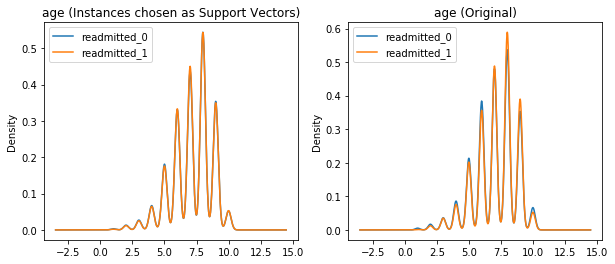

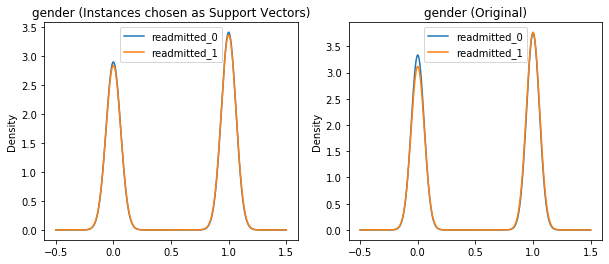

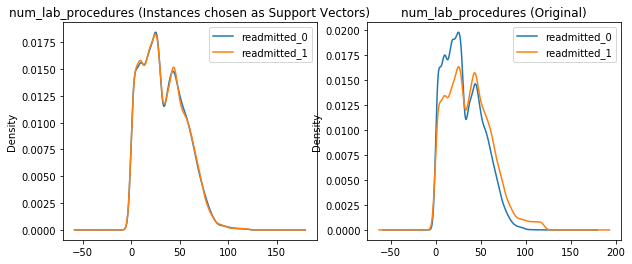

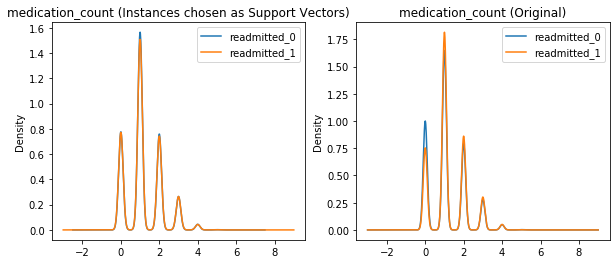

In [91]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['readmitted_tf'])
df_grouped = df_imputed.groupby(['readmitted_tf'])

# plot KDE of Different variables
vars_to_plot = ['age','gender','num_lab_procedures','medication_count']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['readmitted_0','readmitted_1'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['readmitted_0','readmitted_1'])
    plt.title(v+' (Original)')

### SVM 2 -- Linear Kernel for SVM

In [ ]:
## Warning: this cell takes approx 15 minutes to run 
#Try linear kernel for SVM
#Run linear kernel once to show that has lower accuracy for our dataset. The reason can be seen from PCA plots. PCA plots here show our data is not linearaly separable. (We did not reduce dimensions in this case, so we did not create a scree plot.)


#did not update every time, just run once to show that linear kernel has lower accuracy in our data.
#try linear kernel, 25 mins run , ACC worse
#more feature engineering can be done to improve the acc
from sklearn.svm import SVC
# train the model just as before
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object
y_hat = svm_clf.predict(X_test_scaled)
#print("Done")

In [ ]:
from sklearn import metrics as mt

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

#accuracy: 0.614031639972487
#[[9672 1312]
# [6544 2826]]

Create PCA plot to see if our dataset is linearaly separable

In [ ]:
#reduce dimensionality of data set to 2 feauters.
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X_train)
pca_2d = pca.transform(X_train)


#part of the code was taken from:
#http://www.dummies.com/programming/big-data/data-science/how-to-visualize-the-classifier-in-an-svm-supervised-learning-model/
import pylab as pl
plt.figure(figsize=(20,15))
for i in range(0, pca_2d.shape[0]):
    if y_train[i] == 0:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r', s=1,marker='+')
    elif y_train[i] == 1:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g', s=20,marker='*')
pl.legend([c1, c2], ['Not readmitted', 'Readmitted'])
pl.title('Diabetes data set')
pl.show()

The PCA plot below is for dataset with log transfromation of numerical variables. From these plots we can see, log transfromation of numerical variables change the look of pca plot siginficantly. Both PCA plots show our data is not linearaly separable.

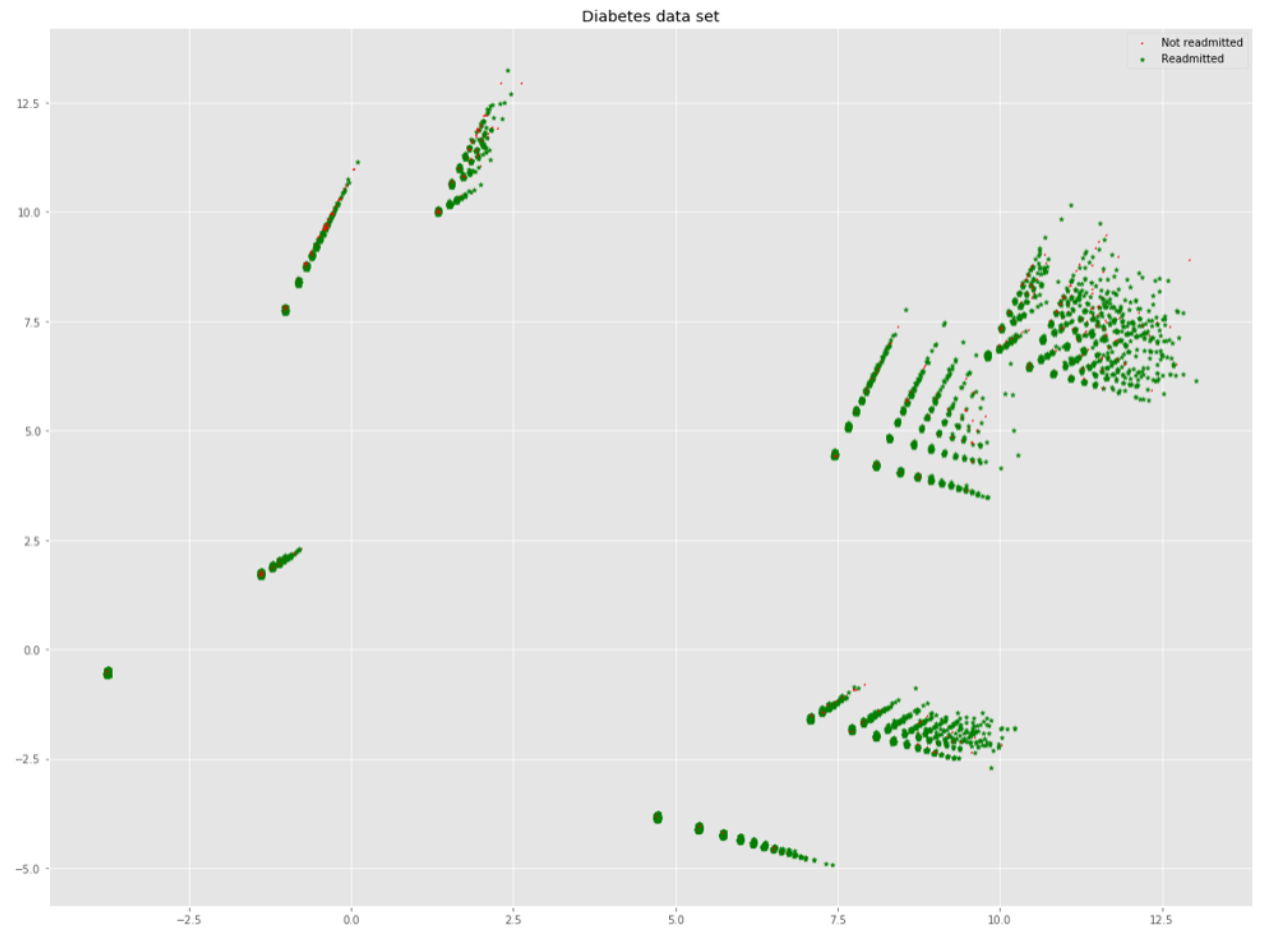

In [68]:
from IPython.display import Image
Image(filename='/Users/samanthasprague/Downloads/PCA1.png')

### SVM 3 -- SGD SVM

In [ ]:
%%time

#SGD made SVM model train fast. this was done in seconds comparing with no SGD 14 mins run.
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn import metrics as mt
cv = StratifiedShuffleSplit( n_splits=1,test_size=0.5)
# use some compact notation for creating a linear SVM classifier with stichastic descent
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('SVM_SGD:', acc)

Runtime comparsion of SVM vs. SVM_SGD
From the results below, we can see SVM_SGD runs 1000X faster than SVM, from 14 mins in SVM to 708 ms in SVM_SGD. SGD does help the SVM model to trian in a reasonable timeframe.

## SVM 4+ Models:
A number of models were built to explore on the effect of log transformation of numerical variables and feature engineering. We did not include the code for all of them, but we summarize the performances of all models below. Below is a summary of the models used above for SVM 1-3. These models used extensive feature creation methods to gain similar accuracies to the LR models above.

SVM 1 SVM - RBF: 0.6822

SVM 2 SVM - Linear: 0.6140

SVM 3 SVM SGD - RBF: 0.6554


Other models built but not present in this analysis notebook are below. Bold are the variations made on the input data to asses performance. These models did not provide the same accuracy as advanced feature creation, but were important in demonstrating the evolution of the models built, and how we arose at the best accuracies of SVMs above. 

**Basic model without log num - baseline:**
* SVM RBF: 0.6293
* SVM SGD - RBF: 0.6098
Note: Data was not linearly seperable so decided to use rbf in future models

**Updated with log num:**
* SVM RBF: 0.6202
* SVM SGD - RBF: 0.6136

**Log num features add more features to increase acc**
* SVM - RBF: 0.6526
* SVM SGD - RBF: 0.6361

**Without log num add more features to increase acc**
* SVM - RBF :0.6588       
* SVM SGD - RBF: 0.6337

More analysis on methods to avoid long training times can be seen in the execeptional work section of this notebook. 

<a id="ModelAdvantages"></a>
## Model Advantages

**Requirements:** Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? 

### Advantages to Logistic Regression Models

**Answer:** 
* Logistic regression models are easier to inperpret and understand
* Have less barriers to entry on the code required to produce a result and intepret
* Code runs in subsecond 
* Feature engineering is easy to apply and manipulate for better results 
* Less parameters to tweak/tune for performance gain

### Advantages to Support Vector Machine Models

**Answer:**
* SVMs can unlock complex relationships not always indentified with LRs 
* Has more parameters that allow for specific tuning 
* Has non-parametric option for increase in accuracy 
* See a large performance gain when leveraging SGD 
* Can be used for many data types 
* Not as sensitive to outliers compared to LR

### Question: Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency?

###### Performance Evalution: Accuracy

| Model Type | Accuracy | AUC |
|------------|----------|-----|
|Logistic Regression 1: OHE, Not Scaled, No Medications | 67% | 74% |
|Logistic Regression 2: SGD, OHE, Not Scaled, No Medications | 58% | 61% | 
|Logistic Regression 3: OHE, Scaled, Medications, Loop | -- | --- | 


| Model Type | Accuracy |
|------------|----------|
|Support Vector Machine 1: RBF Kernel | 68% | 
|Support Vector Machine 2: Linear Kernel | 61% |
|Support Vector Machine 3: SGD SVM RBF Kernel | 65%|


**Answer:** After extensive analysis, we were able to produce accarcies of rough 67-68% for both SVM and LR models. However, it should be noted that the complexity of SVMs provided a lot of hurdles in producing a model that would perform at the same level as the LR using the exact same input data. The time it took to train SVMs provided a lot of hurdles to producing better accuracies. There was far more innovation in creating new features and optimizing run time with the SVM models. While leveraging SGD gave large improvements to both the LR and SVM models, we wanted to be able to evaluate how leverage SGD would effect the performace from an accuracy perspective. You can see the using SGD for the logistic regression model drops the accuracy drastically from 67% to 58%. You can also see from the tables above that leveraging a linear kernel in an SVM also gave sub-par performance. This is likely due to the fact that our data is not linearly seperable. The SGD SVM RBF gives a a 3% drop in accuracy when using the same inputs. Throughout our analysis we were able to improve our model accuracies from approximately 58% to 68% leveraging innovation in new features and model tuning parameters. 

###### Performance Evaluation: Training Time and Effeiciency 

| Model Type | Training Time |
|------------|---------------|
|Logistic Regression 1: OHE, Not Scaled, No Medications| 15.4 seconds | 
|Logistic Regression 2: SGD, OHE, Not Scaled, No Medications| 8 seconds |
|Logistic Regression 3: OHE, Scaled, Medications, Loop| 20 seconds |
|Support Vector Machine 1: RBF Kernel | 14 minutes| 
|Support Vector Machine 2: Linear Kernel| 16 minutes | 
|Support Vector Machine 3: SGD SVM | 7 seconds | 

**Answer:** As you can see from the chart above, logistic regression models had a superior advantage over SVMs in terms of training time and efficiencies when leveraging traditional loss functions. It should be noted that times calculated during runtime displayed were on 2.7 GHz Intel Core i7 with 16 GB of Memory. The run time will differ when the machine exeucting the notebook differs. These times are merely approximate to showcase the magnitude difference from executing an LR to an SVM. This can have major advantages when using large data if the performance of these models are similar. It does not make sense to leverage an SVM unless it provides superior performance to a LR. In our case, the SVM algorithm does not seem to help with preditive power. It make more sense to leverage a LR model due to the effencies gained with an LR.

It should also be noted here that used stochastic gradient decent provides a gain of effeicies to traditional loss functions in both the logistic regression models and SVMs. There is a very large gain of effeiciencies specifically with SVMs. You can see that the RBF Kernel for the traditional loss function takes approximately 14 mintues, where the SDG RBF Kernel takes 7 seconds to run. This provides a 1000x efficiency gain in using SGD for SVMs. The decrease in training for LR is also present, but not as drastic, dropping from 15 second to 8 seconds. Again, these are approximately time values calculated at run time on a MacOS. You can see from the table indicating accuracy, however, that this increase in efficiency for trainings does come with a slight decline in performance. Both the LR and SVM models produced saw a decline in performance when leveraging the SGD. When leveraging large data sets, it should be noted that SGD provides greater gain of efficiencies, but needs to be balanced against the loss of performance. 

<a id="InterpretFeatureImportance"></a>
## Interpret Feature Importance

**Requirements:** Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

Below is a table representation of the most important variables on readmission for diabetes from LR 3. This analysis looks at variables that are likely to both increase and decrease readmission. All variables examined below are specifically called out in the table below. 

| Co-efficent | Name | Value |
|------------|-------| ------|
|$\beta_{1}$| Discharge_Disposition_ID_11 | -0.873 | 
|$\beta_{2}$| Discharge_Disposition_ID_14 | -0.174 | 
|$\beta_{3}$| Discharge_Disposition_ID_23 | 0.373 |
|$\beta_{4}$| Admission_Source_ID_2 | -0.120 | 
|$\beta_{5}$| Admission_Source_ID_10 | 0.508  |
|$\beta_{6}$| Admission_Source_ID_25 | 0.491 |
|$\beta_{7}$| Admission_Type_ID_7 | 0.585 |
|$\beta_{8}$| Admission_Type_ID_3 | -0.106 |
|$\beta_{9}$| Admission_Type_ID_4 | -0.12 |

For the entire set of predictors, we can use this below visualization to examine logistic weights. 

In [ ]:
#Bar plot of the coefficient weights
pd.Series(lr_clf.coef_[0].T,index = df_mlt_hot.columns).plot(kind = 'bar')
plt.show()

### Question:  Explain your interpretation in detail. Why do you think some variables are more important?

**Answer:** 
From sorting the weights of the variables in ascending order above, some variables have more importance then others because they have stronger predictive power. Variables with weights to the left from 0 are responsible for the higher chance of person NOT being readmitted and variables to the right from 0 are responsible for increasing of the chance of the person being readmitted. Seven (7) of the most important can be interpreted in the following way:

* With a discharge disposition of either “Expired” (id 11) or “Hospice / medical facility” (id14), that patient would not likely be readmitted wheras a disposition of “Discharged/transferred to a long term care hospital” (id23) would more likely be re-admitted

* If a patient admission source was a “Clinical Referral” (id 2), s/he would not likely be readmitted as if the admission was a “Transfer from critical access hospital” (id 10) or “Transfer from Ambulatory Surgery Center” (id 25).

* Logically, a patient with an admission type of a “Trauma Center” (id 7) was more likely to be readmitted than a patient where the type is “Elective” (id 3) or “Newborn” (id 4).

* The greater the number of times a patient was an inpatient, the less likely s/he would be readmitted. This is consistent with most treatment practices and insurance coverage. On the contrary, the less the number of times a patient was an outpatient, the more likely s/he would be readmitted.

* Interestingly, the less the number of emergencies a patient had, the more likely s/he would be re-admitted.

* With a range of 1-16 number of diagnoses, nine (9) diagnoses was the number where 49% of patients would likely be readmitted.

* The greater the number of lab procedures a patient underwent suggests that the patient was slightly less likely to be readmitted than patients who did not have as many lab procedures.

<a id="InterpretSupportVectors"></a>
## Interpret Support Vectors

**Requirements:** Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. 

Relooking at the support vectors from SVM 1, we have provided an analysis below: 

In [ ]:
# Taking the code from above and printing it again for easy analysis
# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['readmitted_tf'])
df_grouped = df_imputed.groupby(['readmitted_tf'])

# plot KDE of Different variables
vars_to_plot = ['age','gender','num_lab_procedures','medication_count']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['readmitted_0','readmitted_1'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['readmitted_0','readmitted_1'])
    plt.title(v+' (Original)')

### Question: Do these provide any insight into the data? Explain. 

**Answer:** The feature density plots above show the comparison of the support vectors(left) and the the original feature(right). The feature density plots of age and medication_count vector are very similare to the original ones, showing the support vectors are the most useful data points that they represent the data structure of original data so well. When looking at gender vectors, it has similar to the original on readmitted_1 group but it has lower values in readmitted_0 group at gender 0 (male) comparing to the original data.
When looking at num_lab_procedures vectors, it has similar to the original on readmitted_0 group but it has higher values in readmitted_1 group comparing to the original data.

<a id="Exceptional Work"></a>
## Exceptional Work

Below is code that uses subsampling techniques to help with training time of SVM, and other more advanced techniques like hyper-parameter tuning with GridsearchCV for SVM. These techniques demonstrate advanced knowledge of the model techniques and the in-depth understanding of how to tune SVM models for both effeciencies and performance. 

#### Subsampling technique for SVM

In [ ]:
#%%time
#SGD made SVM model train fast. This was done in seconds comparing with no SGD 14 mins run.
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn import metrics as mt
cv = StratifiedShuffleSplit( n_splits=1,test_size=0.5)
# use some compact notation for creating a linear SVM classifier with stichastic descent
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('SVM_SGD:', acc)

#### GridSearchCV with subsampling w/ smaller parameter list

In [ ]:
#GridSearchCV on subsample
from sklearn import svm, grid_search
from sklearn.model_selection import GridSearchCV

#for the sake of time, to make the run time reasonable, I used only 3 different values for C and 2 different values for gammas.
#runtime this way 3*2*3*10 mins=3hr
#otherwise it would take more than ten hours to run

def svc_param_selection(X, y, nfolds):
    Cs = [0.01, 0.5, 1]
    gammas = [0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
#Warning: this section takes approx 20 min to run 
#%%time
svc_param_selection(X_train_scaled, y_train,3)
#{'C': 1, 'gamma': 0.1}

In [ ]:
#1.6 mins
#%%time
#try SVM with parameters from svc_param_selection() function output c=1, gammas=0.1
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=1, kernel='rbf', degree=3, gamma=0.1) # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled)

from sklearn import metrics as mt

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)  


#Here is the output in case it takes a while to run
#accuracy: 0.6040284942274625
#[[1775  483]
# [1129  684]]

#### GridSearchCV with subsampling with larger parameter list

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm, grid_search
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
##Warning: this code takes a long time to run -- Estimation 1 hr
#actual time
#%%time
svc_param_selection(X_train_scaled, y_train,3)

#Here is the output so you do not need to wait for it to run
#Wall time: 1h 15min 50s
#Out[55]:
#{'C': 1, 'gamma': 0.01}

In [ ]:
#%%time
#try SVM with parameters from svc_param_selection() function output c=1, gammas=0.1
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=1, kernel='rbf', degree=3, gamma=0.01) # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled)

from sklearn import metrics as mt

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)  


#Here is the accuracy so you do not need to run the code
#accuracy: 0.672316384180791
#[[1890  368]
# [ 966  847]]
#Wall time: 41.1 s

<a id="References"></a>
## References



World Health Organization. 10 Facts on Diabetes. https://www.who.int/features/factfiles/diabetes/en/